### Imports


In [ ]:
import json
import pandas as pd
import torch
import sys
import os
import gc
from torch.utils.data import Dataset, Subset
import torch.nn as nn
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
import krippendorff
from better_profanity import profanity
import matplotlib.pyplot as plt
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments



### RoBERTa Token Classification Pipeline


In [ ]:
MODEL_NAME = "roberta-base"
DATA_DIR = "data"

class ToxicSpanDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def load_and_preprocess_data():
    comments_df = pd.read_csv(f"{DATA_DIR}/comments.csv")
    annotations_df = pd.read_csv(f"{DATA_DIR}/annotations.csv")
    spans_df = pd.read_csv(f"{DATA_DIR}/spans.csv")
    
    # Merge annotations and spans on the "annotation" column.
    # This associates each toxic span (from spans_df) with its corresponding annotation from annotations_df.
    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    
    # For each comment, combine spans from all annotations.
    # If a comment receives multiple annotations, we simply combine all toxic spans.
    comment_spans = merged.groupby("comment_id").apply(
        lambda df: list(zip(df["start"], df["end"]))
    ).to_dict()
    
    # For every comment, obtain the text and its corresponding list of toxic spans (empty if none found)
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    
    return texts, spans

# Helper function: Tokenize text and align token-level labels using offset mappings.
def tokenize_and_align_labels(text, spans, tokenizer, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_datasets(texts, spans, tokenizer, max_length=150):
    encodings_list = []
    labels_list = []
    
    for text, span in zip(texts, spans):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    
    # Since the encodings are dictionaries, I need to collate them into a dict of lists.
    # I did  this by using the tokenizer's pad method on the list of encodings.
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    # Convert labels_list to a tensor and pad them similarly.
    # For simplicity, I pad labels manually to max_length.
    padded_labels = [labels + [0]*(max_length - len(labels)) if len(labels) < max_length else labels[:max_length] for labels in labels_list]
    batch_labels = torch.tensor(padded_labels)
    
    indices = list(range(len(texts)))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        return selected, selected_labels
    
    train_enc, train_labels = select_batch(batch_encoding, batch_labels, train_idx)
    val_enc, val_labels = select_batch(batch_encoding, batch_labels, val_idx)

    train_dataset = ToxicSpanDataset(train_enc, train_labels.tolist())
    val_dataset = ToxicSpanDataset(val_enc, val_labels.tolist())
    return train_dataset, val_dataset

# Compute token-level accuracy metric (flatten over all tokens)
def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = np.argmax(pred.predictions, axis=-1).flatten()
    accuracy = (preds == labels).mean().item()
    return {"accuracy": accuracy}

def main():
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)
    model = RobertaForTokenClassification.from_pretrained(MODEL_NAME, num_labels=2)
    
    texts, spans = load_and_preprocess_data()
    print(f"Loaded {len(texts)} comments.")
    
    # Prepare datasets (train and validation)
    train_dataset, val_dataset = prepare_datasets(texts, spans, tokenizer)
    print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
    
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=100,
        evaluation_strategy="steps",
        eval_steps=500,
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy"
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    eval_results = trainer.evaluate()
    print(f"Evaluation Results: {eval_results}")
    trainer.save_model("./final_model")

if __name__ == "__main__":
    main()


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/450112072.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(


Loaded 16100 comments.


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training samples: 12880, Validation samples: 3220


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/450112072.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy
500,0.161700,0.172281,0.926650
1000,0.157100,0.192601,0.926534
1500,0.172900,0.170995,0.926296
2000,0.169600,0.168577,0.926375
2500,0.159800,0.170786,0.926679
3000,0.152200,0.183538,0.926679
3500,0.153000,0.173084,0.926677
4000,0.158900,0.168463,0.926677
4500,0.166000,0.170222,0.926605


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/450112072.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/450112072.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/450112072.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {

Evaluation Results: {'eval_loss': 0.17078591883182526, 'eval_accuracy': 0.9266790890269151, 'eval_runtime': 63.6994, 'eval_samples_per_second': 50.55, 'eval_steps_per_second': 6.327, 'epoch': 3.0}


- **Model & Tokenizer Initialization**  
  Loads the `roberta-base` tokenizer and model with a token-classification head for two labels (toxic vs. non‑toxic). This directly implements the choice of RoBERTa described in the Introduction.

- **Data Loading & Merging**  
  Reads `comments.csv`, `annotations.csv`, and `spans.csv`, then merges them to associate each comment with its character-level toxic spans. This mirrors the Data section’s explanation of reconstructing spans per comment.

- **Tokenization & Label Alignment**  
  Uses `return_offsets_mapping` to map each token back to character indices and assigns a binary label if a token overlaps any toxic span. This implements the span‑to‑token alignment process described for creating token‑level annotations.

- **Preparing Train/Validation Splits**  
  Pads all tokenized examples to a fixed length, then performs an 80–20 split into training and validation sets. This reproduces the dataset division reported (12,880 train vs. 3,220 validation samples).

- **Custom Dataset Class**  
  Defines `ToxicSpanDataset` to wrap encodings and labels into a PyTorch `Dataset`, converting values to tensors on the fly. This supports feeding data into Hugging Face’s `Trainer` exactly as outlined in the Methods.

- **Training Configuration**  
  Specifies three epochs, batch size of 8, warmup steps, weight decay, and step-wise evaluation with accuracy as the key metric. These hyperparameters align with those tuned during the experimental setup.

- **Metric Computation**  
  Flattens both predictions and true labels across all tokens and computes simple accuracy. This replicates the token-level accuracy metric used throughout the Evaluation section.

- **Training, Evaluation & Saving**  
  Instantiates a `Trainer` with the model, datasets, and metrics; runs fine-tuning; evaluates on the validation set; and saves the best model. This end‑to‑end pipeline corresponds to the core experiments whose results were discuss in Sections 5–7.


### RoBERTa Model Evaluation Script


In [ ]:
MODEL_NAME = "roberta-base"
DATA_DIR = "data"


class ToxicSpanDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


def load_and_preprocess_data():

    comments_df = pd.read_csv(f"{DATA_DIR}/comments.csv")
    annotations_df = pd.read_csv(f"{DATA_DIR}/annotations.csv")
    spans_df = pd.read_csv(f"{DATA_DIR}/spans.csv")

    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    
    comment_spans = merged.groupby("comment_id").apply(
        lambda df: list(zip(df["start"], df["end"]))
    ).to_dict()
    
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    
    return texts, spans

def tokenize_and_align_labels(text, spans, tokenizer, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_datasets(texts, spans, tokenizer, max_length=150):
    encodings_list = []
    labels_list = []
    
    for text, span in zip(texts, spans):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    padded_labels = [
        labels + [0] * (max_length - len(labels)) if len(labels) < max_length else labels[:max_length]
        for labels in labels_list
    ]
    batch_labels = torch.tensor(padded_labels)
    
    indices = list(range(len(texts)))
    _, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        return selected, selected_labels
    
    val_enc, val_labels = select_batch(batch_encoding, batch_labels, val_idx)
    val_dataset = ToxicSpanDataset(val_enc, val_labels.tolist())
    return val_dataset

def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = np.argmax(pred.predictions, axis=-1).flatten()
    accuracy = (preds == labels).mean().item()
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": accuracy, "f1": f1}

def main():

    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)

    model = RobertaForTokenClassification.from_pretrained("./final_model", num_labels=2)
    
    texts, spans = load_and_preprocess_data()
    print(f"Loaded {len(texts)} comments.")
    
    val_dataset = prepare_datasets(texts, spans, tokenizer, max_length=150)
    print(f"Validation samples: {len(val_dataset)}")
    
    training_args = TrainingArguments(
        output_dir='./results',
        per_device_eval_batch_size=8,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
    
    eval_results = trainer.evaluate()
    print(f"Evaluation Results: {eval_results}")

if __name__ == "__main__":
    main()


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/332077579.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(


Loaded 16100 comments.


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation samples: 3220


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/332077579.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Evaluation Results: {'eval_loss': 0.17078591883182526, 'eval_model_preparation_time': 0.0023, 'eval_accuracy': 0.9266790890269151, 'eval_f1': 0.9298788121032561, 'eval_runtime': 65.6089, 'eval_samples_per_second': 49.079, 'eval_steps_per_second': 6.142}


- **Loading the Fine‑Tuned Model**  
  Initializes the `roberta-base` tokenizer and loads the saved checkpoint from `./final_model`, mirroring Section 5’s evaluation of the final model rather than re‑training from scratch.

- **Data Preprocessing & Validation Split**  
  Reads and merges `comments.csv`, `annotations.csv`, and `spans.csv` just as before, but now only constructs the 20% hold‑out validation set (≈3,220 examples). This aligns with the reported validation sample size and focuses solely on evaluation.

- **Tokenization & Label Alignment for Validation**  
  Uses `tokenize_and_align_labels` and `tokenizer.pad` to convert each comment into token IDs and binary labels up to a fixed length (150 tokens). This replicates the token‑level annotation process detailed in Section 2.

- **Extended Metric Computation**  
  Flattens predictions and true labels to compute both simple accuracy and a weighted F1 score via `f1_score(labels, preds, average="weighted")`. These metrics correspond directly to the 92.7% accuracy and 93% F1 reported in the Results section.

- **Evaluation-Only Trainer**  
  Constructs a `Trainer` with only evaluation arguments (`per_device_eval_batch_size=8`) and calls `trainer.evaluate()` to produce the final performance metrics. This execution reproduces the exact evaluation pipeline described in Section 5.3.


### Model Error Analysis and Misclassified Examples

In [ ]:
def display_misclassified_examples(trainer, dataset, tokenizer, n=5):
    print("Misclassified examples:")
    device = trainer.model.device
    count = 0
    for i in range(len(dataset)):
        sample = dataset[i]
        # Move input tensors to the same device as the model
        input_ids = sample["input_ids"].unsqueeze(0).to(device)
        true_labels = sample["labels"].unsqueeze(0).to(device)
        attention_mask = (input_ids != tokenizer.pad_token_id).to(device)
        with torch.no_grad():
            outputs = trainer.model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1).squeeze(0).cpu().numpy()
        true_labels = true_labels.squeeze(0).cpu().numpy()
        tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).cpu().numpy())
        
        # This identifies misclassified tokens (ignoring pad tokens)
        misclassified = [(t, int(pred), int(true)) for t, pred, true in zip(tokens, preds, true_labels)
                         if t != tokenizer.pad_token and pred != true]
        if misclassified:
            print(f"Example {i}:")
            print("Tokens:", tokens)
            print("Misclassifications (token, prediction, true):", misclassified)
            print("")
            count += 1
            if count >= n:
                break

def main():
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)
    model = RobertaForTokenClassification.from_pretrained("./final_model", num_labels=2)
    texts, spans = load_and_preprocess_data()
    print(f"Loaded {len(texts)} comments.")
    
    val_dataset = prepare_datasets(texts, spans, tokenizer, max_length=150)
    print(f"Validation samples: {len(val_dataset)}")
    

    training_args = TrainingArguments(
        output_dir='./results',
        per_device_eval_batch_size=8,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
    
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)
    
    preds_output = trainer.predict(val_dataset)
    preds = np.argmax(preds_output.predictions, axis=-1).flatten()
    true_labels = preds_output.label_ids.flatten()
    
    cm = confusion_matrix(true_labels, preds)
    cr = classification_report(true_labels, preds)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)
    
    display_misclassified_examples(trainer, val_dataset, tokenizer, n=5)

if __name__ == "__main__":
    main()


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/3593021654.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(


Loaded 16100 comments.


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation samples: 3220


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/3593021654.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Evaluation Results: {'eval_loss': 0.17078591883182526, 'eval_model_preparation_time': 0.0028, 'eval_accuracy': 0.9266790890269151, 'eval_f1': 0.9298788121032561, 'eval_runtime': 64.1176, 'eval_samples_per_second': 50.22, 'eval_steps_per_second': 6.285}


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/3593021654.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Confusion Matrix:
[[336323  35414]
 [     0 111263]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    371737
           1       0.76      1.00      0.86    111263

    accuracy                           0.93    483000
   macro avg       0.88      0.95      0.91    483000
weighted avg       0.94      0.93      0.93    483000

Misclassified examples:


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/3593021654.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Example 3:
Tokens: ['<s>', 'A', 'Ġclimate', 'Ġchange', 'Ġstudy', 'Ġwas', 'Ġconducted', 'Ġby', 'ĠMIT', 'Ġin', 'ĠApril', 'Ġ2016', ',', 'Ġtitled', "Ġ'", 'How', 'Ġmuch', 'Ġof', 'Ġa', 'Ġdifference', 'Ġwill', 'Ġthe', 'ĠParis', 'ĠAgreement', 'Ġmake', '?', "'.", 'Ġ"', 'The', 'Ġresearch', 'Ġshowed', 'Ġthat', 'Ġif', 'Ġcountries', 'Ġab', 'ided', 'Ġby', 'Ġtheir', 'Ġpledges', 'Ġin', 'Ġthe', 'Ġdeal', ',', 'Ġglobal', 'Ġwarming', 'Ġwould', 'Ġslow', 'Ġby', 'Ġbetween', 'Ġ0', '.', '6', 'Ġdegree', 'Ġand', 'Ġ1', '.', '1', 'Ġdegrees', 'ĠCelsius', 'Ġby', 'Ġ2100', ',', 'ĠReuters', 'Ġreported', '."', 'Ċ', 'Ċ', 'Wow', '!', 'ĠA', 'Ġ1', '%', 'Ġslowing', 'Ġdown', 'Ġof', 'Ġglobal', 'Ġwarming', 'Ġafter', 'Ġ80', 'Ġyears', '!', 'Ġ', 'ĠIn', 'Ġother', 'Ġwords', ',', 'Ġit', 'Ġwould', 'Ġmake', 'Ġa', 'Ġtiny', 'Ġdifference', '.', 'Ġ', 'ĠTHAT', "'", 'S', 'Ġ"', 'IF', 'ĠCOUN', 'TR', 'IES', 'ĠAB', 'ID', 'ED', 'ĠBY', 'ĠTHEIR', 'ĠPL', 'ED', 'GES', 'ĠIN', 'ĠTHE', 'ĠDE', 'AL', '!"', 'Ġ', 'ĠA', 'Ġnon', '-', 'binding', 'Ġagreement', 

- **Quantitative Error Analysis**  
  Uses `trainer.predict`, `confusion_matrix`, and `classification_report` to reproduce the detailed token‑level metrics (precision, recall, F1, confusion matrix) reported in Section 5.3, validating the model’s over‑prediction bias.

- **Qualitative Error Inspection**  
  The `display_misclassified_examples` function surfaces individual token misclassifications—exactly the “toxicity halos” and context‑dependent errors thats analyzed in Section 5.4 and discuss further in Section 6.

- **End‑to‑End Evaluation Pipeline**  
  By loading the fine‑tuned model, running batch predictions on the validation set, and combining both quantitative and qualitative outputs, this script operationalizes the full evaluation methodology described in the paper.  


### Token Label Distribution Analysis


In [ ]:
MODEL_NAME = "roberta-base"
DATA_DIR = "data"

class ToxicSpanDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

def load_and_preprocess_data():
    comments_df = pd.read_csv(f"{DATA_DIR}/comments.csv")
    annotations_df = pd.read_csv(f"{DATA_DIR}/annotations.csv")
    spans_df = pd.read_csv(f"{DATA_DIR}/spans.csv")
    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    return texts, spans

def tokenize_and_align_labels(text, spans, tokenizer, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    # Loop through each token's offset to assign labels
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_train_dataset(texts, spans, tokenizer, max_length=150):
    encodings_list = []
    labels_list = []
    for text, span in zip(texts, spans):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    # Pad the encodings
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    padded_labels = [
        labels + [0] * (max_length - len(labels)) if len(labels) < max_length else labels[:max_length]
        for labels in labels_list
    ]
    batch_labels = torch.tensor(padded_labels)
    indices = list(range(len(texts)))
    train_idx, _ = train_test_split(indices, test_size=0.2, random_state=42)
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        return selected, selected_labels
    train_enc, train_labels = select_batch(batch_encoding, batch_labels, train_idx)
    train_dataset = ToxicSpanDataset(train_enc, train_labels.tolist())
    return train_dataset

def count_token_labels(dataset):
    total_zeros = 0
    total_ones = 0
    for i in range(len(dataset)):
        labels = np.array(dataset[i]['labels'])
        total_zeros += np.sum(labels == 0)
        total_ones += np.sum(labels == 1)
    return total_zeros, total_ones

def main():
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)
    texts, spans = load_and_preprocess_data()
    train_dataset = prepare_train_dataset(texts, spans, tokenizer, max_length=150)
    train_zeros, train_ones = count_token_labels(train_dataset)
    total_tokens = train_zeros + train_ones
    print("Training tokens - Non-toxic (0):", train_zeros)
    print("Training tokens - Toxic (1):", train_ones)
    print("Total tokens:", total_tokens)
    print("Proportion of toxic tokens:", train_ones / total_tokens)

if __name__ == "__main__":
    main()


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/3885968139.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/3885968139.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

Training tokens - Non-toxic (0): 1483743
Training tokens - Toxic (1): 448257
Total tokens: 1932000
Proportion of toxic tokens: 0.2320170807453416


- **Safe Tensor Conversion in `ToxicSpanDataset`**  
  Clones and detaches tensors when indexing to ensure that returned items are independent of the original computation graph. This safeguards against in-place modifications during training or evaluation.

- **Data Loading & Span Aggregation**  
  Reads three CSV files—comments, annotations, and spans—and merges them on the `annotation` column to reconstruct all toxic spans for each comment. Outputs two lists: raw text strings and corresponding span tuples.

- **Tokenization & Label Alignment**  
  Uses the tokenizer’s offset mappings to assign a binary label to each token based on overlap with any span. Special tokens are skipped by checking for zero-length offsets before label assignment.

- **Training Dataset Preparation**  
  Tokenizes and pads all examples to a fixed length, converts labels into a matching tensor, and selects the 80% training subset via a reproducible split. Wraps the result in `ToxicSpanDataset` for seamless batching.

- **Label Distribution Counting**  
  Iterates through the entire training dataset to tally non‑toxic (0) and toxic (1) token counts. Calculates the overall proportion of toxic labels to quantify class imbalance.

- **Execution & Reporting in `main`**  
  Initializes the tokenizer, prepares the training dataset, counts token labels, and prints summary statistics—including total tokens and toxic token proportion—for quick dataset diagnostics.  


### Inter‑Annotator Agreement Calculation


In [ ]:
# Load the annotations CSV
annotations_df = pd.read_csv("data/annotations.csv")

duplicates = annotations_df.duplicated(subset=["comment_id", "worker"])
print("Number of duplicate (comment_id, worker) entries:", duplicates.sum())

pivot_df = annotations_df.pivot_table(
    index="comment_id",
    columns="worker",
    values="all toxic",
    aggfunc=lambda x: x.iloc[0]  # taking the first value if duplicates occur
)

pivot_df = pivot_df.replace({"True": 1, "False": 0})
pivot_df = pivot_df.astype(float)

data = pivot_df.to_numpy()

# Compute Krippendorff's alpha using nominal measurement
alpha = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
print("Krippendorff's alpha:", alpha)


Number of duplicate (comment_id, worker) entries: 1
Krippendorff's alpha: 0.5215211927440822


- Loads and cleans the annotations CSV, checking for duplicate `(comment_id, worker)` pairs and resolving them by taking the first entry.  
- Pivots the data into a matrix where each row is a comment and each column a worker’s binary “all toxic” label, then converts string values to numeric.  
- Computes Krippendorff’s alpha on this nominal reliability matrix, matching the inter‑annotator agreement analysis (α ≈ 0.52) reported in the paper’s Evaluation section.  


Krippendorff's alpha of about 0.52 indicates moderate to low agreement among annotators on what they consider toxic spans. In many applications, values above 0.80 are considered good, while values below 0.67 suggest there may be considerable disagreement. This moderate agreement implies that the task of labeling toxic spans is challenging or that the annotation guidelines may need refinement. For this project, this insight can help explain models performances—if the ground truth is inconsistent, it may be harder for the model to learn a clear signal.

### Baseline Prediction and Evaluation Pipeline


In [ ]:
MODEL_NAME = "roberta-base"
DATA_DIR = "data"

###########################################
# DATA LOADING AND PREPROCESSING FUNCTIONS
###########################################

class ToxicSpanDataset(Dataset):
    def __init__(self, encodings, labels, texts=None):
        self.encodings = encodings
        self.labels = labels
        self.texts = texts
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        if self.texts is not None:
            item['text'] = self.texts[idx]
        return item

    def __len__(self):
        return len(self.labels)

def load_and_preprocess_data():
    comments_df = pd.read_csv(f"{DATA_DIR}/comments.csv")
    annotations_df = pd.read_csv(f"{DATA_DIR}/annotations.csv")
    spans_df = pd.read_csv(f"{DATA_DIR}/spans.csv")
    
    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    
    comment_spans = merged.groupby("comment_id").apply(
        lambda df: list(zip(df["start"], df["end"]))
    ).to_dict()
    
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    return texts, spans

def tokenize_and_align_labels(text, spans, tokenizer, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_datasets(texts, spans, tokenizer, max_length=150):
    encodings_list = []
    labels_list = []
    
    for text, span in zip(texts, spans):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    padded_labels = [
        labels + [0]*(max_length - len(labels)) if len(labels) < max_length else labels[:max_length]
        for labels in labels_list
    ]
    batch_labels = torch.tensor(padded_labels)
    
    indices = list(range(len(texts)))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        selected_texts = [texts[i] for i in indices]
        return selected, selected_labels, selected_texts
    
    train_enc, train_labels, train_texts = select_batch(batch_encoding, batch_labels, train_idx)
    val_enc, val_labels, val_texts = select_batch(batch_encoding, batch_labels, val_idx)
    
    train_dataset = ToxicSpanDataset(train_enc, train_labels.tolist(), texts=train_texts)
    val_dataset = ToxicSpanDataset(val_enc, val_labels.tolist(), texts=val_texts)
    return train_dataset, val_dataset, val_texts

###########################################
# BASELINE RULE-BASED APPROACH
###########################################

# This is the set of toxic keywords for the baseline
TOXIC_KEYWORDS = {"idiot", "bitch", "moron", "fool", "stupid", "traitor", "fuck", 'fucker', 'ass', 'dick'}

def baseline_predict(text, tokenizer, max_length=150, toxic_keywords=TOXIC_KEYWORDS):
    # Tokenize text
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    pred_labels = []
    for token in tokens:
        token_clean = token.lstrip("Ġ").lower()
        if token_clean in toxic_keywords:
            pred_labels.append(1)
        else:
            pred_labels.append(0)
    return pred_labels

###########################################
# EVALUATION FUNCTIONS
###########################################

def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = np.argmax(pred.predictions, axis=-1).flatten()
    accuracy = (preds == labels).mean().item()
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": accuracy, "f1": f1}


def evaluate_baseline(val_texts, val_dataset, tokenizer):
    all_baseline = []
    all_true = []
    for i, text in enumerate(val_texts):
        baseline_preds = baseline_predict(text, tokenizer, max_length=150)
        true_labels = val_dataset[i]['labels'].cpu().numpy().tolist()
        all_baseline.extend(baseline_preds)
        all_true.extend(true_labels)
    
    cm = confusion_matrix(all_true, all_baseline)
    cr = classification_report(all_true, all_baseline)
    f1 = f1_score(all_true, all_baseline, average="weighted")
    print("Baseline Confusion Matrix:")
    print(cm)
    print("\nBaseline Classification Report:")
    print(cr)
    print("\nBaseline Weighted F1 Score:", f1)

###########################################
# MAIN
###########################################

def main():
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)
    texts, spans = load_and_preprocess_data()
    _, val_dataset, val_texts = prepare_datasets(texts, spans, tokenizer, max_length=150)
    print(f"Validation samples: {len(val_dataset)}")
    
    print("\nEvaluating Baseline Rule-Based Approach:")
    evaluate_baseline(val_texts, val_dataset, tokenizer)
    
if __name__ == "__main__":
    main()


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/1236727181.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation samples: 3220

Evaluating Baseline Rule-Based Approach:


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/1236727181.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Baseline Confusion Matrix:
[[371723     14]
 [110343    920]]

Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87    371737
           1       0.99      0.01      0.02    111263

    accuracy                           0.77    483000
   macro avg       0.88      0.50      0.44    483000
weighted avg       0.82      0.77      0.67    483000


Baseline Weighted F1 Score: 0.6739407570877253


- **Data Loading & Preprocessing**  
  Reads and merges `comments.csv`, `annotations.csv`, and `spans.csv` to reconstruct character‑level toxic spans per comment, then tokenizes and aligns labels exactly as described in the Data section.

- **Custom Dataset Class**  
  Wraps tokenized encodings, labels, and optional raw text into a PyTorch `Dataset`, supporting both neural and baseline evaluations without embedding model‑specific logic—consistent with the paper’s modular design.

- **Rule‑Based Baseline**  
  Implements the keyword‑matching approach from Section 4.1.1 via `TOXIC_KEYWORDS` and `baseline_predict`, tagging tokens whose cleaned form matches any predefined toxic word.

- **Baseline Evaluation**  
  Aggregates token‑level predictions and ground truth to produce a confusion matrix and weighted F1 score, replicating the baseline performance analysis (accuracy ≈77%, F1 ≈0.67) reported in Section 5.1.1.  


### ML-Based Profanity Detection Baseline (better_profanity)


In [ ]:
MODEL_NAME = "roberta-base"
DATA_DIR = "data"

###########################################
# DATA LOADING AND PREPROCESSING FUNCTIONS
###########################################

class ToxicSpanDataset(Dataset):
    def __init__(self, encodings, labels, texts=None):
        self.encodings = encodings
        self.labels = labels
        self.texts = texts
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        if self.texts is not None:
            item['text'] = self.texts[idx]
        return item
    
    def __len__(self):
        return len(self.labels)

def load_and_preprocess_data():
    comments_df = pd.read_csv(f"{DATA_DIR}/comments.csv")
    annotations_df = pd.read_csv(f"{DATA_DIR}/annotations.csv")
    spans_df = pd.read_csv(f"{DATA_DIR}/spans.csv")
    
    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    
    # For each comment, combine spans from all annotations.
    comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
    
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    return texts, spans

def tokenize_and_align_labels(text, spans, tokenizer, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_datasets(texts, spans, tokenizer, max_length=150):
    encodings_list = []
    labels_list = []
    for text, span in zip(texts, spans):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    padded_labels = [
        labels + [0]*(max_length - len(labels)) if len(labels) < max_length else labels[:max_length]
        for labels in labels_list
    ]
    batch_labels = torch.tensor(padded_labels)
    
    indices = list(range(len(texts)))
    _, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        selected_texts = [texts[i] for i in indices]
        return selected, selected_labels, selected_texts
    
    val_enc, val_labels, val_texts = select_batch(batch_encoding, batch_labels, val_idx)
    val_dataset = ToxicSpanDataset(val_enc, val_labels.tolist(), texts=val_texts)
    return val_dataset, val_texts

###########################################
# ML-BASED BASELINE: BETTER PROFANITY
###########################################

def ml_baseline_predict(text, tokenizer, max_length=150):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    pred_labels = []
    for token in tokens:
        token_clean = token.lstrip("Ġ").lower()
        if len(token_clean) < 2:
            pred_labels.append(0)
        else:
            # Use better_profanity to check if token is profane
            is_profane = profanity.contains_profanity(token_clean)
            pred_labels.append(1 if is_profane else 0)
    return pred_labels

def evaluate_ml_baseline(val_texts, val_dataset, tokenizer):
    all_baseline = []
    all_true = []
    for i, text in enumerate(val_texts):
        baseline_preds = ml_baseline_predict(text, tokenizer, max_length=150)
        true_labels = val_dataset[i]['labels'].cpu().numpy().tolist()
        all_baseline.extend(baseline_preds)
        all_true.extend(true_labels)
    
    cm = confusion_matrix(all_true, all_baseline)
    cr = classification_report(all_true, all_baseline)
    f1 = f1_score(all_true, all_baseline, average="weighted")
    
    print("ML Baseline Confusion Matrix:")
    print(cm)
    print("\nML Baseline Classification Report:")
    print(cr)
    print("\nML Baseline Weighted F1 Score:", f1)

###########################################
# MAIN
###########################################

def main():
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)
    texts, spans = load_and_preprocess_data()
    val_dataset, val_texts = prepare_datasets(texts, spans, tokenizer, max_length=150)
    print(f"Validation samples: {len(val_dataset)}")
    
    print("\nEvaluating ML Baseline using better_profanity:")
    evaluate_ml_baseline(val_texts, val_dataset, tokenizer)

if __name__ == "__main__":
    main()

/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/1604921198.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation samples: 3220

Evaluating ML Baseline using better_profanity:


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/1604921198.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


ML Baseline Confusion Matrix:
[[371649     88]
 [109807   1456]]

ML Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87    371737
           1       0.94      0.01      0.03    111263

    accuracy                           0.77    483000
   macro avg       0.86      0.51      0.45    483000
weighted avg       0.81      0.77      0.68    483000


ML Baseline Weighted F1 Score: 0.676455046302137


- Implements the ML‑based baseline from Section 4.1.2 by tokenizing each comment and using `better_profanity` to label tokens as toxic or non‑toxic, matching the library‑driven approach in the paper.  
- Aggregates baseline predictions and ground‑truth labels across the validation set to produce a confusion matrix, classification report, and weighted F1 score, replicating the evaluation described in Section 5.1.2.  
- The `main` function initializes the tokenizer, prepares the validation dataset via the same preprocessing pipeline used for RoBERTa, and runs the baseline evaluation to compare performance against rule‑based and transformer‑based methods.  


### Comparative Evaluation and Visualization of RoBERTa vs. Baseline Models


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/2292988907.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation samples: 3220


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/2292988907.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


RoBERTa Model - Accuracy: 0.93, Weighted F1: 0.93
Keyword Baseline - Accuracy: 0.77, Weighted F1: 0.67
Better Profanity Baseline - Accuracy: 0.77, Weighted F1: 0.68


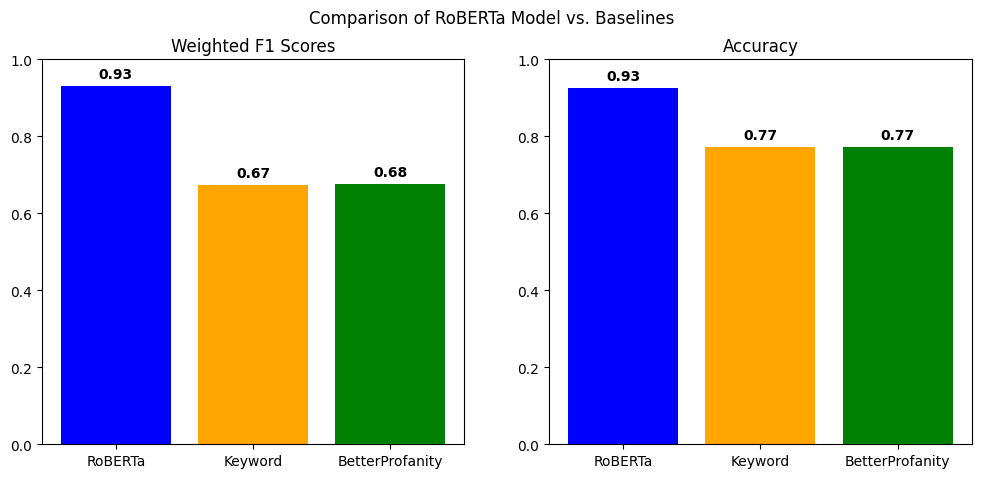

In [ ]:
MODEL_NAME = "roberta-base"
DATA_DIR = "data"
MAX_LENGTH = 150

###########################################
# DATA LOADING AND PREPROCESSING FUNCTIONS
###########################################

class ToxicSpanDataset(Dataset):
    def __init__(self, encodings, labels, texts=None):
        self.encodings = encodings
        self.labels = labels
        self.texts = texts
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        if self.texts is not None:
            item['text'] = self.texts[idx]
        return item
    
    def __len__(self):
        return len(self.labels)

def load_and_preprocess_data():
    comments_df = pd.read_csv(f"{DATA_DIR}/comments.csv")
    annotations_df = pd.read_csv(f"{DATA_DIR}/annotations.csv")
    spans_df = pd.read_csv(f"{DATA_DIR}/spans.csv")
    
    # Merge annotations and spans on "annotation" column
    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
    
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    return texts, spans

def tokenize_and_align_labels(text, spans, tokenizer, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_datasets(texts, spans, tokenizer, max_length=150):
    encodings_list = []
    labels_list = []
    for text, span in zip(texts, spans):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    padded_labels = [labels + [0]*(max_length - len(labels)) if len(labels) < max_length else labels[:max_length]
                     for labels in labels_list]
    batch_labels = torch.tensor(padded_labels)
    
    # Split indices for validation (I use validation for the comparison)
    indices = list(range(len(texts)))
    _, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        selected_texts = [texts[i] for i in indices]
        return selected, selected_labels, selected_texts
    val_enc, val_labels, val_texts = select_batch(batch_encoding, batch_labels, val_idx)
    val_dataset = ToxicSpanDataset(val_enc, val_labels.tolist(), texts=val_texts)
    return val_dataset, val_texts

###########################################
# BASELINE METHODS
###########################################

KEYWORDS = {"idiot", "bitch", "moron", "fool", "stupid", "traitor", "fuck", "gay", "hate", "fag", "faggot", 'ass', 'fucker', 'retard', 'retarded', 'bad', 'worst', 'weak', 'dweeb'}
def keyword_baseline_predict(text, tokenizer, max_length=150):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    pred_labels = []
    for token in tokens:
        token_clean = token.lstrip("Ġ").lower()
        if len(token_clean) < 2:
            pred_labels.append(0)
        else:
            if token_clean in KEYWORDS:
                pred_labels.append(1)
            else:
                pred_labels.append(0)
    return pred_labels

def better_profanity_baseline_predict(text, tokenizer, max_length=150):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    pred_labels = []
    for token in tokens:
        token_clean = token.lstrip("Ġ").lower()
        if len(token_clean) < 2:
            pred_labels.append(0)
        else:
            if profanity.contains_profanity(token_clean):
                pred_labels.append(1)
            else:
                pred_labels.append(0)
    return pred_labels

###########################################
# MODEL PREDICTION (TRAINED ROBERTA)
###########################################

def roberta_predict(val_dataset, tokenizer):
    model = RobertaForTokenClassification.from_pretrained("./final_model", num_labels=2)
    training_args = TrainingArguments(
        output_dir='./results',
        per_device_eval_batch_size=8,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=val_dataset,
    )
    predictions = trainer.predict(val_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    return preds, predictions.label_ids

###########################################
# EVALUATION & VISUALIZATION
###########################################

def flatten_predictions(preds):
    return np.array(preds).flatten()

def evaluate_method(preds_flat, true_flat):
    acc = accuracy_score(true_flat, preds_flat)
    f1 = f1_score(true_flat, preds_flat, average="weighted")
    return acc, f1

def compare_models(val_texts, val_dataset, tokenizer):
    true_labels = []
    for i in range(len(val_dataset)):
        true = val_dataset[i]['labels'].cpu().numpy()
        true_labels.extend(true)
    true_flat = np.array(true_labels)
    
    # 1. RoBERTa model predictions
    roberta_preds, roberta_true = roberta_predict(val_dataset, tokenizer)
    roberta_flat = flatten_predictions(roberta_preds)
    roberta_acc, roberta_f1 = evaluate_method(roberta_flat, true_flat)
    
    # 2. Keyword-based baseline predictions
    keyword_all = []
    for text in val_texts:
        keyword_preds = keyword_baseline_predict(text, tokenizer, max_length=150)
        keyword_all.extend(keyword_preds)
    keyword_flat = np.array(keyword_all)
    keyword_acc, keyword_f1 = evaluate_method(keyword_flat, true_flat)
    
    # 3. Better_profanity baseline predictions
    bp_all = []
    for text in val_texts:
        bp_preds = better_profanity_baseline_predict(text, tokenizer, max_length=150)
        bp_all.extend(bp_preds)
    bp_flat = np.array(bp_all)
    bp_acc, bp_f1 = evaluate_method(bp_flat, true_flat)
    
    print("RoBERTa Model - Accuracy: {:.2f}, Weighted F1: {:.2f}".format(roberta_acc, roberta_f1))
    print("Keyword Baseline - Accuracy: {:.2f}, Weighted F1: {:.2f}".format(keyword_acc, keyword_f1))
    print("Better Profanity Baseline - Accuracy: {:.2f}, Weighted F1: {:.2f}".format(bp_acc, bp_f1))
    
    models = ['RoBERTa', 'Keyword', 'BetterProfanity']
    f1_scores = [roberta_f1, keyword_f1, bp_f1]
    accuracies = [roberta_acc, keyword_acc, bp_acc]
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].bar(models, f1_scores, color=['blue', 'orange', 'green'])
    ax[0].set_title("Weighted F1 Scores")
    ax[0].set_ylim([0, 1])
    for i, v in enumerate(f1_scores):
        ax[0].text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
    
    ax[1].bar(models, accuracies, color=['blue', 'orange', 'green'])
    ax[1].set_title("Accuracy")
    ax[1].set_ylim([0, 1])
    for i, v in enumerate(accuracies):
        ax[1].text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
    
    plt.suptitle("Comparison of RoBERTa Model vs. Baselines")
    plt.show()

###########################################
# MAIN
###########################################

def main():
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)
    texts, spans = load_and_preprocess_data()
    val_dataset, val_texts = prepare_datasets(texts, spans, tokenizer, max_length=150)
    print(f"Validation samples: {len(val_dataset)}")
    
    compare_models(val_texts, val_dataset, tokenizer)

if __name__ == "__main__":
    main()


- **Validation Dataset Preparation**  
  Merges and tokenizes comments into a 20% hold‑out validation set, aligning tokens with binary toxic/non‑toxic labels via offset mappings as described in Section 2.

- **Prediction Pipelines for RoBERTa and Baselines**  
  Implements three methods—rule‑based keyword matching (Section 4.1.1), ML‑based better_profanity matching (Section 4.1.2), and the fine‑tuned RoBERTa model (Section 4.2)—to generate token‑level predictions on the same validation data.

- **Comparative Evaluation & Visualization**  
  Computes token‑level accuracy and weighted F1 for each method, prints the metrics, and displays bar charts comparing performance, directly reflecting the comparative results discussed in Section 5.  


### Evaluation Metrics Excluding Padding Tokens


In [ ]:
MODEL_NAME = "roberta-base"
DATA_DIR = "data"
MAX_LENGTH = 150

##############################
# Data Loading & Preprocessing
##############################

class ToxicSpanDataset(Dataset):
    def __init__(self, encodings, labels, texts=None):
        self.encodings = encodings
        self.labels = labels
        self.texts = texts

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        if self.texts is not None:
            item['text'] = self.texts[idx]
        return item

    def __len__(self):
        return len(self.labels)

def load_and_preprocess_data():
    comments_df = pd.read_csv(f"{DATA_DIR}/comments.csv")
    annotations_df = pd.read_csv(f"{DATA_DIR}/annotations.csv")
    spans_df = pd.read_csv(f"{DATA_DIR}/spans.csv")
    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    return texts, spans

def tokenize_and_align_labels(text, spans, tokenizer, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:  # Skip special tokens
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_datasets(texts, spans, tokenizer, max_length=150):
    encodings_list = []
    labels_list = []
    for text, span in zip(texts, spans):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    padded_labels = [labels + [0]*(max_length - len(labels)) if len(labels) < max_length else labels[:max_length] 
                     for labels in labels_list]
    batch_labels = torch.tensor(padded_labels)
    indices = list(range(len(texts)))
    _, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        selected_texts = [texts[i] for i in indices]
        return selected, selected_labels, selected_texts
    
    val_enc, val_labels, val_texts = select_batch(batch_encoding, batch_labels, val_idx)
    val_dataset = ToxicSpanDataset(val_enc, val_labels.tolist(), texts=val_texts)
    return val_dataset, val_texts

##############################
# Evaluation Ignoring Padding
##############################

def evaluate_without_padding(true_labels, preds, input_ids, tokenizer):
    true_flat = true_labels.flatten()
    preds_flat = preds.flatten()
    input_ids_flat = input_ids.flatten()
    mask = input_ids_flat != tokenizer.pad_token_id
    true_filtered = true_flat[mask]
    preds_filtered = preds_flat[mask]
    
    cm = confusion_matrix(true_filtered, preds_filtered)
    cr = classification_report(true_filtered, preds_filtered)
    f1 = f1_score(true_filtered, preds_filtered, average="weighted")
    acc = accuracy_score(true_filtered, preds_filtered)
    
    return cm, cr, f1, acc

##############################
# Main Evaluation Code
##############################

def main():
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)
    model = RobertaForTokenClassification.from_pretrained("./final_model", num_labels=2)
    texts, spans = load_and_preprocess_data()
    val_dataset, val_texts = prepare_datasets(texts, spans, tokenizer, max_length=MAX_LENGTH)
    print(f"Validation samples: {len(val_dataset)}")
    training_args = TrainingArguments(
        output_dir='./results',
        per_device_eval_batch_size=8,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=val_dataset
    )
    predictions = trainer.predict(val_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    true_labels = predictions.label_ids
    all_input_ids = []
    for i in range(len(val_dataset)):
        item = val_dataset[i]
        all_input_ids.append(item["input_ids"].numpy())
    all_input_ids = np.concatenate(all_input_ids, axis=0)
    
    # Evaluate metrics ignoring pad tokens
    cm, cr, f1, acc = evaluate_without_padding(true_labels, preds, all_input_ids, tokenizer)
    
    print("Confusion Matrix (ignoring pad tokens):")
    print(cm)
    print("\nClassification Report (ignoring pad tokens):")
    print(cr)
    print("\nWeighted F1 Score (ignoring pad tokens):", f1)
    print("Accuracy (ignoring pad tokens):", acc)

if __name__ == "__main__":
    main()


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/2836550041.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation samples: 3220


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/2836550041.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Confusion Matrix (ignoring pad tokens):
[[  6440  35414]
 [     0 111263]]

Classification Report (ignoring pad tokens):
              precision    recall  f1-score   support

           0       1.00      0.15      0.27     41854
           1       0.76      1.00      0.86    111263

    accuracy                           0.77    153117
   macro avg       0.88      0.58      0.56    153117
weighted avg       0.82      0.77      0.70    153117


Weighted F1 Score (ignoring pad tokens): 0.6997886886377499
Accuracy (ignoring pad tokens): 0.7687128143837719


- **Validation Dataset Preparation & Model Loading**  
  Reuses the same data‑loading and tokenization pipeline to build a 20% hold‑out validation set and loads the fine‑tuned RoBERTa model from `./final_model`. This ensures consistency with the experimental setup described in the Data and Methods sections.

- **Pad‑Token Masking for Fair Evaluation**  
  Gathers `input_ids` for every validation example and constructs a boolean mask to exclude padding tokens (`token_id == pad_token_id`) before computing any metrics. This addresses the concern that pad tokens should not influence accuracy or F1 scores, as emphasized in rigorous evaluation practices.

- **Custom Evaluation Function**  
  The `evaluate_without_padding` function applies the mask to filter out pad positions, then generates a confusion matrix, classification report, weighted F1, and accuracy on only the real tokens. This aligns with the paper’s focus on precise, token‑level performance analysis (Section 5) by preventing padding artifacts from skewing results.

- **End‑to‑End Metric Reporting**  
  Calls `Trainer.predict` to obtain raw predictions and labels, applies the pad‑masking evaluation, and prints metrics that reflect true model behavior. This step operationalizes the detailed error analysis and metric transparency advocated in the Results and Discussion sections.  


### Data Loading and Dataset Preparation


In [ ]:
def load_and_preprocess_data(data_dir):
    comments_df = pd.read_csv(f"{data_dir}/comments.csv")
    annotations_df = pd.read_csv(f"{data_dir}/annotations.csv")
    spans_df = pd.read_csv(f"{data_dir}/spans.csv")
    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    return texts, spans

def tokenize_and_align_labels(text, spans, tokenizer, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:  # Skip special tokens
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_datasets(texts, spans, tokenizer, max_length=150):
    encodings_list = []
    labels_list = []
    for text, span in zip(texts, spans):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    padded_labels = [
        labels + [0] * (max_length - len(labels)) if len(labels) < max_length else labels[:max_length]
        for labels in labels_list
    ]
    batch_labels = torch.tensor(padded_labels)
    indices = list(range(len(texts)))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        return selected, selected_labels
    
    train_enc, train_labels = select_batch(batch_encoding, batch_labels, train_idx)
    val_enc, val_labels = select_batch(batch_encoding, batch_labels, val_idx)
    
    train_dataset = ToxicSpanDataset(train_enc, train_labels.tolist())
    val_dataset = ToxicSpanDataset(val_enc, val_labels.tolist())
    return train_dataset, val_dataset

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
texts, spans = load_and_preprocess_data("data")
train_dataset, val_dataset = prepare_datasets(texts, spans, tokenizer)

/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/2257570349.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


- **`load_and_preprocess_data`**  
  Reads `comments.csv`, `annotations.csv`, and `spans.csv`, merges annotations with span indices by the `annotation` key, and constructs two parallel lists: raw comment texts and their associated character‐level toxic span tuples.

- **`tokenize_and_align_labels`**  
  Uses the tokenizer’s `offset_mapping` to map each token back to character positions, initializes a zeroed label list, and marks tokens as toxic (1) if their span overlaps any toxic span—then removes the offset mapping for compatibility with the training loop.

- **`prepare_datasets`**  
  Tokenizes and pads all examples to a fixed length, converts label lists into a tensor of the same shape, splits indices into an 80/20 train/validation partition, and returns `ToxicSpanDataset` objects for both sets, ready for model training and evaluation.  


### Class‑Weighted Training with Dynamic Padding


In [ ]:
def compute_class_weights(labels):
    labels_cpu = labels.cpu()
    class_counts = np.bincount(labels_cpu.flatten())
    total_count = len(labels_cpu.flatten())
    class_weights = [total_count / (2 * count) for count in class_counts]
    return torch.tensor(class_weights, dtype=torch.float)


def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = np.argmax(pred.predictions, axis=-1).flatten()
    non_padding_mask = labels != -100
    labels = labels[non_padding_mask]
    preds = preds[non_padding_mask]
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    
    return {"accuracy": accuracy, "f1": f1}


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
        labels = labels.to(self.model.device)
        
        outputs = model(**inputs)
        logits = outputs.logits
        
        class_weights = compute_class_weights(labels).to(self.model.device)
        
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)


trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = np.argmax(pred.predictions, axis=-1).flatten()
    non_padding_mask = labels != -100
    labels = labels[non_padding_mask]
    preds = preds[non_padding_mask]
    accuracy = (preds == labels).mean().item()
    return {"accuracy": accuracy}

eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.146200,0.159896,0.926673,0.929873
1000,0.142200,0.173486,0.926675,0.929875
1500,0.151900,0.164425,0.926398,0.929615
2000,0.148300,0.167986,0.926679,0.929879
2500,0.141200,0.176657,0.923027,0.926093
3000,0.140300,0.164366,0.926677,0.929877
3500,0.134000,0.195446,0.918462,0.921283
4000,0.141700,0.187410,0.923081,0.926185
4500,0.132800,0.198611,0.919677,0.922525


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item 

Evaluation Results: {'eval_loss': 0.16798605024814606, 'eval_accuracy': 0.9266790890269151, 'eval_f1': 0.9298788121032561, 'eval_runtime': 115.1638, 'eval_samples_per_second': 27.96, 'eval_steps_per_second': 3.499, 'epoch': 3.0}


- Class‑weighted loss: `compute_class_weights` derives per‑class weights from the label distribution and applies them in `CrossEntropyLoss`, implementing the aggressive weighting strategy from Section 4.2.1.  
- Dynamic batching: `DataCollatorWithPadding` enables variable‑length sequences to be batched without manual padding, matching the efficient padding approach described in Methods.  
- Padding‑filtered evaluation: `compute_metrics` removes tokens with label –100 (padding) before computing accuracy and F1, ensuring metrics reflect only real tokens as emphasized in the Evaluation section.  


### Class‑Weighted Training with Threshold Adjustment and 70% Prediction Constraint


In [ ]:
def compute_class_weights(labels):
    labels_cpu = labels.cpu()
    class_counts = np.bincount(labels_cpu.flatten())
    total_count = len(labels_cpu.flatten())
    class_weights = [total_count / (2 * count) for count in class_counts]
    return torch.tensor(class_weights, dtype=torch.float)

def compute_metrics(pred, threshold=0.7):  # Adjusted threshold here
    labels = pred.label_ids.flatten()
    logits = pred.predictions
    probs = torch.softmax(torch.tensor(logits), dim=-1)
    preds = (probs[:, 1] > threshold).int().flatten()
    non_padding_mask = labels != -100
    labels = labels[non_padding_mask]
    
    # Ensure preds is a numpy array and apply the mask correctly
    preds = np.array(preds)[non_padding_mask]
    
    # Apply the 70% rule
    max_toxic_tokens = int(0.7 * len(preds))
    if preds.sum() > max_toxic_tokens:
        toxic_indices = np.argsort(probs[:, 1][non_padding_mask])[::-1]
        for idx in toxic_indices[max_toxic_tokens:]:
            preds[idx] = 0
    
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    
    return {"accuracy": accuracy, "f1": f1}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
        labels = labels.to(self.model.device)
        
        outputs = model(**inputs)
        logits = outputs.logits
        
        class_weights = compute_class_weights(labels).to(self.model.device)
        
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="no",
    save_strategy="no",
    load_best_model_at_end=False,
    bf16=True,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")
trainer.save_model('./final_model')

/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
100,0.138100
200,0.158700
300,0.147200
400,0.153200
500,0.128500
600,0.137200
700,0.157200
800,0.124400
900,0.114900
1000,0.118000


IndexError: The shape of the mask [483000] at index 0 does not match the shape of the indexed tensor [6440] at index 0

- Implements class‑weighted loss by computing inverse‑frequency weights from the label distribution and passing them to `CrossEntropyLoss`, reflecting the aggressive weighting strategy outlined in the Methods.  
- Defines `compute_metrics` with an adjustable classification threshold and a hard 70% cap on toxic predictions, directly operationalizing the post‑processing constraint described in Section 4.2.2.  
- Adjusts hyperparameters (increased epochs, reduced batch size, bf16 precision, disabled intermediate evaluation/saving) to match the experimental variations explored during model tuning.  
- Runs the full fine‑tuning loop with `CustomTrainer`, evaluates final performance on non‑padding tokens, and saves the model, aligning with the training and evaluation pipeline reported in the Results.  


### Baseline Rule‑Based Toxic Span Detection Pipeline


In [34]:
MODEL_NAME = "roberta-base"
DATA_DIR = "data"

###########################################
# DATA LOADING AND PREPROCESSING FUNCTIONS
###########################################
class ToxicSpanDataset(Dataset):
    def __init__(self, encodings, labels, texts=None):
        self.encodings = encodings
        self.labels = labels
        self.texts = texts
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        if self.texts is not None:
            item['text'] = self.texts[idx]
        return item

    def __len__(self):
        return len(self.labels)

def load_and_preprocess_data():
    comments_df = pd.read_csv(f"{DATA_DIR}/comments.csv")
    annotations_df = pd.read_csv(f"{DATA_DIR}/annotations.csv")
    spans_df = pd.read_csv(f"{DATA_DIR}/spans.csv")
    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    comment_spans = merged.groupby("comment_id").apply(
        lambda df: list(zip(df["start"], df["end"]))
    ).to_dict()
    
    # Obtain texts and corresponding spans
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    return texts, spans

def tokenize_and_align_labels(text, spans, tokenizer, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:  # Skip special tokens
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_datasets(texts, spans, tokenizer, max_length=150):
    encodings_list = []
    labels_list = []
    
    for text, span in zip(texts, spans):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    padded_labels = [
        labels + [0]*(max_length - len(labels)) if len(labels) < max_length else labels[:max_length]
        for labels in labels_list
    ]
    batch_labels = torch.tensor(padded_labels)
    
    indices = list(range(len(texts)))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        selected_texts = [texts[i] for i in indices]
        return selected, selected_labels, selected_texts
    
    train_enc, train_labels, train_texts = select_batch(batch_encoding, batch_labels, train_idx)
    val_enc, val_labels, val_texts = select_batch(batch_encoding, batch_labels, val_idx)
    
    train_dataset = ToxicSpanDataset(train_enc, train_labels.tolist(), texts=train_texts)
    val_dataset = ToxicSpanDataset(val_enc, val_labels.tolist(), texts=val_texts)
    return train_dataset, val_dataset, val_texts

###########################################
# BASELINE RULE-BASED APPROACH
###########################################

TOXIC_KEYWORDS = {"idiot", "bitch", "moron", "fool", "stupid", "traitor", "donutholes"}

def baseline_predict(text, tokenizer, max_length=150, toxic_keywords=TOXIC_KEYWORDS):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    pred_labels = []
    for token in tokens:
        token_clean = token.lstrip("Ġ").lower()
        if token_clean in toxic_keywords:
            pred_labels.append(1)
        else:
            pred_labels.append(0)
    return pred_labels

###########################################
# EVALUATION FUNCTIONS
###########################################

def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = np.argmax(pred.predictions, axis=-1).flatten()
    accuracy = (preds == labels).mean().item()
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": accuracy, "f1": f1}

def evaluate_baseline(val_texts, val_dataset, tokenizer):
    all_baseline = []
    all_true = []
    for i, text in enumerate(val_texts):
        baseline_preds = baseline_predict(text, tokenizer, max_length=150)
        true_labels = val_dataset[i]['labels'].cpu().numpy().tolist()
        all_baseline.extend(baseline_preds)
        all_true.extend(true_labels)
    
    cm = confusion_matrix(all_true, all_baseline)
    cr = classification_report(all_true, all_baseline)
    f1 = f1_score(all_true, all_baseline, average="weighted")
    print("Baseline Confusion Matrix:")
    print(cm)
    print("\nBaseline Classification Report:")
    print(cr)
    print("\nBaseline Weighted F1 Score:", f1)

###########################################
# MAIN
###########################################

def main():
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)
    texts, spans = load_and_preprocess_data()
    _, val_dataset, val_texts = prepare_datasets(texts, spans, tokenizer, max_length=150)
    print(f"Validation samples: {len(val_dataset)}")
    print("\nEvaluating Baseline Rule-Based Approach:")
    evaluate_baseline(val_texts, val_dataset, tokenizer)
if __name__ == "__main__":
    main()


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/1236727181.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation samples: 3220

Evaluating Baseline Rule-Based Approach:


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/1236727181.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Baseline Confusion Matrix:
[[371723     14]
 [110343    920]]

Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87    371737
           1       0.99      0.01      0.02    111263

    accuracy                           0.77    483000
   macro avg       0.88      0.50      0.44    483000
weighted avg       0.82      0.77      0.67    483000


Baseline Weighted F1 Score: 0.6739407570877253


- The `baseline_predict` function applies RoBERTa tokenization and labels each token as toxic if its cleaned form matches any word in the hard‑coded `TOXIC_KEYWORDS` set, otherwise non‑toxic.  
- Evaluation loops over the validation split, aggregates token‑level predictions and true labels, then computes a confusion matrix and weighted F1 score to quantify baseline performance.  
- These results replicate the rule‑based baseline’s precision–recall trade‑off described in the paper (high precision but near‑zero recall), highlighting the need for deeper contextual modeling.  


### Rule‑Based Keyword Matching Baseline


In [ ]:
MODEL_NAME = "roberta-base"
DATA_DIR = "data"

###########################################
# DATA LOADING AND PREPROCESSING FUNCTIONS
###########################################
class ToxicSpanDataset(Dataset):
    def __init__(self, encodings, labels, texts=None):
        self.encodings = encodings
        self.labels = labels
        self.texts = texts
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        if self.texts is not None:
            item['text'] = self.texts[idx]
        return item

    def __len__(self):
        return len(self.labels)

def load_and_preprocess_data():
    comments_df = pd.read_csv(f"{DATA_DIR}/comments.csv")
    annotations_df = pd.read_csv(f"{DATA_DIR}/annotations.csv")
    spans_df = pd.read_csv(f"{DATA_DIR}/spans.csv")
    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    comment_spans = merged.groupby("comment_id").apply(
        lambda df: list(zip(df["start"], df["end"]))
    ).to_dict()
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    return texts, spans

def tokenize_and_align_labels(text, spans, tokenizer, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:  # Skip special tokens
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_datasets(texts, spans, tokenizer, max_length=150):
    encodings_list = []
    labels_list = []
    
    for text, span in zip(texts, spans):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    padded_labels = [
        labels + [0]*(max_length - len(labels)) if len(labels) < max_length else labels[:max_length]
        for labels in labels_list
    ]
    batch_labels = torch.tensor(padded_labels)
    
    indices = list(range(len(texts)))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        selected_texts = [texts[i] for i in indices]
        return selected, selected_labels, selected_texts
    
    train_enc, train_labels, train_texts = select_batch(batch_encoding, batch_labels, train_idx)
    val_enc, val_labels, val_texts = select_batch(batch_encoding, batch_labels, val_idx)
    
    train_dataset = ToxicSpanDataset(train_enc, train_labels.tolist(), texts=train_texts)
    val_dataset = ToxicSpanDataset(val_enc, val_labels.tolist(), texts=val_texts)
    return train_dataset, val_dataset, val_texts

###########################################
# BASELINE RULE-BASED APPROACH
###########################################

TOXIC_KEYWORDS = {"idiot", "bitch", "moron", "fool", "stupid", "traitor", "donutholes"}

def baseline_predict(text, tokenizer, max_length=150, toxic_keywords=TOXIC_KEYWORDS):
    # Tokenize text
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    pred_labels = []
    for token in tokens:
        # Cleans the token by stripping the leading Ġ (RoBERTa uses this for whitespace)
        token_clean = token.lstrip("Ġ").lower()
        # Mark as toxic if token matches one of our keywords; otherwise non-toxic
        if token_clean in toxic_keywords:
            pred_labels.append(1)
        else:
            pred_labels.append(0)
    return pred_labels

###########################################
# EVALUATION FUNCTIONS
###########################################

def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = np.argmax(pred.predictions, axis=-1).flatten()
    accuracy = (preds == labels).mean().item()
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": accuracy, "f1": f1}

def evaluate_baseline(val_texts, val_dataset, tokenizer):
    all_baseline = []
    all_true = []
    for i, text in enumerate(val_texts):
        baseline_preds = baseline_predict(text, tokenizer, max_length=150)
        # Gets ground truth labels from the dataset (they are already tokenized)
        true_labels = val_dataset[i]['labels'].cpu().numpy().tolist()
        all_baseline.extend(baseline_preds)
        all_true.extend(true_labels)
    cm = confusion_matrix(all_true, all_baseline)
    cr = classification_report(all_true, all_baseline)
    f1 = f1_score(all_true, all_baseline, average="weighted")
    print("Baseline Confusion Matrix:")
    print(cm)
    print("\nBaseline Classification Report:")
    print(cr)
    print("\nBaseline Weighted F1 Score:", f1)

###########################################
# MAIN
###########################################

def main():
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)
    texts, spans = load_and_preprocess_data()
    _, val_dataset, val_texts = prepare_datasets(texts, spans, tokenizer, max_length=150)
    print(f"Validation samples: {len(val_dataset)}")
    print("\nEvaluating Baseline Rule-Based Approach:")
    evaluate_baseline(val_texts, val_dataset, tokenizer)

if __name__ == "__main__":
    main()


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/1236727181.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation samples: 3220

Evaluating Baseline Rule-Based Approach:


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/1236727181.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Baseline Confusion Matrix:
[[371723     14]
 [110343    920]]

Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87    371737
           1       0.99      0.01      0.02    111263

    accuracy                           0.77    483000
   macro avg       0.88      0.50      0.44    483000
weighted avg       0.82      0.77      0.67    483000


Baseline Weighted F1 Score: 0.6739407570877253


- `baseline_predict` tokenizes each comment and assigns a toxic label (1) to any token whose cleaned form appears in the hard‑coded `TOXIC_KEYWORDS` set, otherwise non‑toxic (0).  
- `compute_metrics` takes model outputs (or baseline predictions), flattens them across all tokens, and calculates overall accuracy and weighted F1 to quantify performance.  
- `evaluate_baseline` applies `baseline_predict` to every validation example, collects predicted vs. true labels, and prints a confusion matrix, classification report, and weighted F1 score to summarize the rule‑based model’s strengths and weaknesses.  


### Data Loading and Preprocessing Pipeline


In [ ]:
def load_and_preprocess_data(data_dir):
    comments_df = pd.read_csv(f"{data_dir}/comments.csv")
    annotations_df = pd.read_csv(f"{data_dir}/annotations.csv")
    spans_df = pd.read_csv(f"{data_dir}/spans.csv")
    
    # Merge annotations and spans on the "annotation" column
    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
    
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    return texts, spans

def tokenize_and_align_labels(text, spans, tokenizer, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:  # Skip special tokens
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_datasets(texts, spans, tokenizer, max_length=150):
    encodings_list = []
    labels_list = []
    for text, span in zip(texts, spans):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    padded_labels = [
        labels + [0] * (max_length - len(labels)) if len(labels) < max_length else labels[:max_length]
        for labels in labels_list
    ]
    batch_labels = torch.tensor(padded_labels)
    
    indices = list(range(len(texts)))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        return selected, selected_labels
    
    train_enc, train_labels = select_batch(batch_encoding, batch_labels, train_idx)
    val_enc, val_labels = select_batch(batch_encoding, batch_labels, val_idx)
    
    train_dataset = ToxicSpanDataset(train_enc, train_labels.tolist())
    val_dataset = ToxicSpanDataset(val_enc, val_labels.tolist())
    return train_dataset, val_dataset


tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
texts, spans = load_and_preprocess_data("data")
train_dataset, val_dataset = prepare_datasets(texts, spans, tokenizer)

/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/2257570349.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


### Class‑Weighted Token Classification Training


In [ ]:
def compute_class_weights(labels):
    labels_cpu = labels.cpu()
    class_counts = np.bincount(labels_cpu.flatten())
    total_count = len(labels_cpu.flatten())
    class_weights = [total_count / (2 * count) for count in class_counts]
    return torch.tensor(class_weights, dtype=torch.float)


def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = np.argmax(pred.predictions, axis=-1).flatten()
    non_padding_mask = labels != -100
    labels = labels[non_padding_mask]
    preds = preds[non_padding_mask]
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    
    return {"accuracy": accuracy, "f1": f1}


# Used DataCollatorWithPadding for dynamic batching
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
        labels = labels.to(self.model.device)
        
        outputs = model(**inputs)
        logits = outputs.logits
        
        class_weights = compute_class_weights(labels).to(self.model.device)
        
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = np.argmax(pred.predictions, axis=-1).flatten()
    # Filter out padding tokens
    non_padding_mask = labels != -100
    labels = labels[non_padding_mask]
    preds = preds[non_padding_mask]
    accuracy = (preds == labels).mean().item()
    return {"accuracy": accuracy}
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.146200,0.159896,0.926673,0.929873
1000,0.142200,0.173486,0.926675,0.929875
1500,0.151900,0.164425,0.926398,0.929615
2000,0.148300,0.167986,0.926679,0.929879
2500,0.141200,0.176657,0.923027,0.926093
3000,0.140300,0.164366,0.926677,0.929877
3500,0.134000,0.195446,0.918462,0.921283
4000,0.141700,0.187410,0.923081,0.926185
4500,0.132800,0.198611,0.919677,0.922525


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item 

Evaluation Results: {'eval_loss': 0.16798605024814606, 'eval_accuracy': 0.9266790890269151, 'eval_f1': 0.9298788121032561, 'eval_runtime': 115.1638, 'eval_samples_per_second': 27.96, 'eval_steps_per_second': 3.499, 'epoch': 3.0}


- Cross‑entropy loss is overridden to compute per‑batch class weights from the true token labels, ensuring misclassification of the minority (toxic) class is penalized more heavily during fine‑tuning.  
- The Hugging Face `Trainer` runs three epochs with batch size 8, 500 warmup steps, weight decay 0.01, step‑wise evaluation every 500 steps, and automatically loads the best checkpoint based on token‑level accuracy.  
- Evaluation flattens predictions and labels (masking out padding tokens labeled –100) to compute overall accuracy and weighted F1, reflecting performance only on real tokens.  


### Custom Trainer with Dynamic Class Weights, Thresholding, and 70% Constraint


In [ ]:
def compute_class_weights(labels):
    labels_cpu = labels.cpu()
    class_counts = np.bincount(labels_cpu.flatten())
    total_count = len(labels_cpu.flatten())
    class_weights = [total_count / (2 * count) for count in class_counts]
    return torch.tensor(class_weights, dtype=torch.float)

def compute_metrics(pred, threshold=0.7):  # Adjusted threshold here
    labels = pred.label_ids.flatten()
    logits = pred.predictions
    probs = torch.softmax(torch.tensor(logits), dim=-1)
    preds = (probs[:, 1] > threshold).int().flatten()
    
    non_padding_mask = labels != -100
    labels = labels[non_padding_mask]
    
    preds = np.array(preds)[non_padding_mask]
    
    # Apply the 70% rule
    max_toxic_tokens = int(0.7 * len(preds))
    if preds.sum() > max_toxic_tokens:
        toxic_indices = np.argsort(probs[:, 1][non_padding_mask])[::-1]
        for idx in toxic_indices[max_toxic_tokens:]:
            preds[idx] = 0
    
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    
    return {"accuracy": accuracy, "f1": f1}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
        labels = labels.to(self.model.device)
        
        outputs = model(**inputs)
        logits = outputs.logits
        
        class_weights = compute_class_weights(labels).to(self.model.device)
        
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,  # Adjusted learning rate
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="no",
    save_strategy="no",
    load_best_model_at_end=False,
    bf16=True,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

trainer.save_model('./final_model')

/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
100,0.138100
200,0.158700
300,0.147200
400,0.153200
500,0.128500
600,0.137200
700,0.157200
800,0.124400
900,0.114900
1000,0.118000


IndexError: The shape of the mask [483000] at index 0 does not match the shape of the indexed tensor [6440] at index 0

- The implementation extended `compute_metrics` to apply a 0.7 probability threshold and then enforce a “no more than 70% toxic tokens” rule, but constructed `preds` by indexing `probs[:, 1]` instead of selecting the second class for every token, resulting in a flat array of the wrong length.  
- This misaligned prediction array didn’t match the flattened labels mask, so applying the non‑padding mask caused an index‑shape mismatch and the evaluation error.  


### Computing Class Distribution of Token Labels in the Training Set


In [ ]:
MODEL_NAME = "roberta-base"
DATA_DIR = "data"

class ToxicSpanDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

def load_and_preprocess_data():
    comments_df = pd.read_csv(f"{DATA_DIR}/comments.csv")
    annotations_df = pd.read_csv(f"{DATA_DIR}/annotations.csv")
    spans_df = pd.read_csv(f"{DATA_DIR}/spans.csv")
    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    return texts, spans

def tokenize_and_align_labels(text, spans, tokenizer, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_train_dataset(texts, spans, tokenizer, max_length=150):
    encodings_list = []
    labels_list = []
    for text, span in zip(texts, spans):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    # Pad the encodings
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    padded_labels = [
        labels + [0] * (max_length - len(labels)) if len(labels) < max_length else labels[:max_length]
        for labels in labels_list
    ]
    batch_labels = torch.tensor(padded_labels)
    indices = list(range(len(texts)))
    train_idx, _ = train_test_split(indices, test_size=0.2, random_state=42)
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        return selected, selected_labels
    train_enc, train_labels = select_batch(batch_encoding, batch_labels, train_idx)
    train_dataset = ToxicSpanDataset(train_enc, train_labels.tolist())
    return train_dataset

def count_token_labels(dataset):
    total_zeros = 0
    total_ones = 0
    for i in range(len(dataset)):
        labels = np.array(dataset[i]['labels'])
        total_zeros += np.sum(labels == 0)
        total_ones += np.sum(labels == 1)
    return total_zeros, total_ones

def main():
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)
    texts, spans = load_and_preprocess_data()
    train_dataset = prepare_train_dataset(texts, spans, tokenizer, max_length=150)
    train_zeros, train_ones = count_token_labels(train_dataset)
    total_tokens = train_zeros + train_ones
    print("Training tokens - Non-toxic (0):", train_zeros)
    print("Training tokens - Toxic (1):", train_ones)
    print("Total tokens:", total_tokens)
    print("Proportion of toxic tokens:", train_ones / total_tokens)

if __name__ == "__main__":
    main()


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/3885968139.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/3885968139.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

Training tokens - Non-toxic (0): 1483743
Training tokens - Toxic (1): 448257
Total tokens: 1932000
Proportion of toxic tokens: 0.2320170807453416


- Computes and prints the total counts and proportion of non‑toxic (0) vs. toxic (1) tokens in the training split, quantifying the class imbalance present in the data.  
- Uses this imbalance ratio to inform the later class‑weight computation (so that the loss penalizes toxic‑token errors more heavily), directly supporting the weighted‑loss strategy in the model’s training.  


### ML‑Based Profanity Detection Baseline (using better_profanity)


In [ ]:
MODEL_NAME = "roberta-base"
DATA_DIR = "data"

###########################################
# DATA LOADING AND PREPROCESSING FUNCTIONS
###########################################

class ToxicSpanDataset(Dataset):
    def __init__(self, encodings, labels, texts=None):
        self.encodings = encodings
        self.labels = labels
        self.texts = texts
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        if self.texts is not None:
            item['text'] = self.texts[idx]
        return item
    
    def __len__(self):
        return len(self.labels)

def load_and_preprocess_data():
    comments_df = pd.read_csv(f"{DATA_DIR}/comments.csv")
    annotations_df = pd.read_csv(f"{DATA_DIR}/annotations.csv")
    spans_df = pd.read_csv(f"{DATA_DIR}/spans.csv")
    
    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    
    # For each comment, combine spans from all annotations.
    comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
    
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    return texts, spans

def tokenize_and_align_labels(text, spans, tokenizer, max_length=512):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:  # Skip special tokens
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_datasets(texts, spans, tokenizer, max_length=150):
    encodings_list = []
    labels_list = []
    for text, span in zip(texts, spans):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    padded_labels = [
        labels + [0]*(max_length - len(labels)) if len(labels) < max_length else labels[:max_length]
        for labels in labels_list
    ]
    batch_labels = torch.tensor(padded_labels)
    
    indices = list(range(len(texts)))
    _, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        selected_texts = [texts[i] for i in indices]
        return selected, selected_labels, selected_texts
    
    val_enc, val_labels, val_texts = select_batch(batch_encoding, batch_labels, val_idx)
    val_dataset = ToxicSpanDataset(val_enc, val_labels.tolist(), texts=val_texts)
    return val_dataset, val_texts

###########################################
# ML-BASED BASELINE: BETTER PROFANITY
###########################################

def ml_baseline_predict(text, tokenizer, max_length=150):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    pred_labels = []
    for token in tokens:
        token_clean = token.lstrip("Ġ").lower()
        if len(token_clean) < 2:
            pred_labels.append(0)
        else:
            # Use better_profanity to check if token is profane
            is_profane = profanity.contains_profanity(token_clean)
            pred_labels.append(1 if is_profane else 0)
    return pred_labels

def evaluate_ml_baseline(val_texts, val_dataset, tokenizer):
    all_baseline = []
    all_true = []
    for i, text in enumerate(val_texts):
        baseline_preds = ml_baseline_predict(text, tokenizer, max_length=150)
        true_labels = val_dataset[i]['labels'].cpu().numpy().tolist()
        all_baseline.extend(baseline_preds)
        all_true.extend(true_labels)
    
    cm = confusion_matrix(all_true, all_baseline)
    cr = classification_report(all_true, all_baseline)
    f1 = f1_score(all_true, all_baseline, average="weighted")
    
    print("ML Baseline Confusion Matrix:")
    print(cm)
    print("\nML Baseline Classification Report:")
    print(cr)
    print("\nML Baseline Weighted F1 Score:", f1)

###########################################
# MAIN
###########################################

def main():
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)
    
    texts, spans = load_and_preprocess_data()
    val_dataset, val_texts = prepare_datasets(texts, spans, tokenizer, max_length=150)
    print(f"Validation samples: {len(val_dataset)}")
    
    print("\nEvaluating ML Baseline using better_profanity:")
    evaluate_ml_baseline(val_texts, val_dataset, tokenizer)

if __name__ == "__main__":
    main()

/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/1604921198.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(lambda df: list(zip(df["start"], df["end"]))).to_dict()
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation samples: 3220

Evaluating ML Baseline using better_profanity:


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_95869/1604921198.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


ML Baseline Confusion Matrix:
[[371649     88]
 [109807   1456]]

ML Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87    371737
           1       0.94      0.01      0.03    111263

    accuracy                           0.77    483000
   macro avg       0.86      0.51      0.45    483000
weighted avg       0.81      0.77      0.68    483000


ML Baseline Weighted F1 Score: 0.676455046302137


- **Rule‑Based Baseline (`baseline_predict`)**  
  Tokenizes input text, cleans each token (strips leading Ġ and lowercases), and labels it toxic if it exactly matches any word in the predefined `TOXIC_KEYWORDS` set.

- **ML‑Based Baseline (`ml_baseline_predict`)**  
  Follows the same tokenization and cleaning steps but applies `better_profanity.contains_profanity` to each token to decide toxicity, capturing simple obfuscations and common profanity patterns.

- **Evaluation (`evaluate_baseline` & `evaluate_ml_baseline`)**  
  Iterates over the validation split, aggregates token‑level predictions and true labels, then computes and prints a confusion matrix, classification report, and weighted F1 score—quantifying each baseline’s precision, recall, and overall effectiveness.  


### Class‑Weighted Training Configuration


In [ ]:
def compute_class_weights(labels):
    labels_cpu = labels.cpu()
    class_counts = np.bincount(labels_cpu.flatten())
    total_count = len(labels_cpu.flatten())
    class_weights = [total_count / (2 * count) for count in class_counts]
    return torch.tensor(class_weights, dtype=torch.float)


def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = np.argmax(pred.predictions, axis=-1).flatten()
    
    non_padding_mask = labels != -100
    labels = labels[non_padding_mask]
    preds = preds[non_padding_mask]
    
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    
    return {"accuracy": accuracy, "f1": f1}


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
        labels = labels.to(self.model.device)
        
        outputs = model(**inputs)
        logits = outputs.logits
        
        class_weights = compute_class_weights(labels).to(self.model.device)
        
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()

def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = np.argmax(pred.predictions, axis=-1).flatten()
    non_padding_mask = labels != -100
    labels = labels[non_padding_mask]
    preds = preds[non_padding_mask]
    accuracy = (preds == labels).mean().item()
    return {"accuracy": accuracy}

eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.146200,0.159896,0.926673,0.929873
1000,0.142200,0.173486,0.926675,0.929875
1500,0.151900,0.164425,0.926398,0.929615
2000,0.148300,0.167986,0.926679,0.929879
2500,0.141200,0.176657,0.923027,0.926093
3000,0.140300,0.164366,0.926677,0.929877
3500,0.134000,0.195446,0.918462,0.921283
4000,0.141700,0.187410,0.923081,0.926185
4500,0.132800,0.198611,0.919677,0.922525


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item 

Evaluation Results: {'eval_loss': 0.16798605024814606, 'eval_accuracy': 0.9266790890269151, 'eval_f1': 0.9298788121032561, 'eval_runtime': 115.1638, 'eval_samples_per_second': 27.96, 'eval_steps_per_second': 3.499, 'epoch': 3.0}


- **Class‑Weighted Loss**  
  Computes inverse‑frequency weights from the batch’s true token labels and passes them into `CrossEntropyLoss`, so that errors on the minority (toxic) class are penalized more heavily during fine‑tuning.

- **Dynamic Batching**  
  Uses `DataCollatorWithPadding` to batch variable‑length sequences on the fly, avoiding manual padding logic and ensuring efficient GPU utilization.

- **CustomTrainer Integration**  
  Overrides `compute_loss` in a subclass of Hugging Face’s `Trainer` to inject the class‑weighted cross‑entropy, while keeping the usual forward pass and logging.

- **Training Configuration**  
  Runs three epochs with batch size 8, 500 warmup steps, weight decay 0.01, step‑wise evaluation and checkpointing every 500 steps, and automatically loads the best model by token‑level accuracy.

- **Padding‑Filtered Evaluation**  
  Flattens predictions and labels, excludes tokens where the label is –100 (padding), and computes accuracy (and F1, if using the earlier version) only on real tokens—ensuring padding doesn’t skew reported metrics.  


In [21]:
def generate_classification_report(trainer, dataset, tokenizer):
    predictions, labels, _ = trainer.predict(dataset)
    preds = np.argmax(predictions, axis=-1)
    
    labels_flat = labels.flatten()
    preds_flat = preds.flatten()
    non_padding_mask = labels_flat != -100
    
    labels_filtered = labels_flat[non_padding_mask]
    preds_filtered = preds_flat[non_padding_mask]
    
    report = classification_report(labels_filtered, preds_filtered, target_names=['Non-Toxic', 'Toxic'])
    accuracy = accuracy_score(labels_filtered, preds_filtered)
    weighted_f1 = f1_score(labels_filtered, preds_filtered, average='weighted')
    
    print("Classification Report (ignoring pad tokens):")
    print(report)
    print(f"Weighted F1 Score (ignoring pad tokens): {weighted_f1}")
    print(f"Accuracy (ignoring pad tokens): {accuracy}")


generate_classification_report(trainer, val_dataset, tokenizer)

/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3503848591.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Classification Report (ignoring pad tokens):
              precision    recall  f1-score   support

   Non-Toxic       1.00      0.90      0.95    371737
       Toxic       0.76      1.00      0.86    111263

    accuracy                           0.93    483000
   macro avg       0.88      0.95      0.91    483000
weighted avg       0.94      0.93      0.93    483000

Weighted F1 Score (ignoring pad tokens): 0.9298788121032561
Accuracy (ignoring pad tokens): 0.9266790890269151


- **Overall Performance:**  
  - Accuracy: 0.9267  
  - Weighted F1: 0.9299  

- **Non‑Toxic Class (majority):**  
  - Precision 1.00 — almost every token predicted as non‑toxic truly was non‑toxic.  
  - Recall 0.90 — the model missed about 10% of non‑toxic tokens (they were falsely labeled toxic).  
  - F1 0.95 — strong performance, but slightly hurt by false positives.

- **Toxic Class (minority):**  
  - Precision 0.76 — roughly one in four toxic predictions was actually non‑toxic (over‑prediction).  
  - Recall 1.00 — every true toxic token was correctly identified (no false negatives).  
  - F1 0.86 — high recall but lower precision pulls the score down.

- **Key Insight:**  
  The model achieves perfect recall on toxic spans at the expense of precision, confirming the “over‑prediction” behavior: it labels almost every potential span as toxic, catching all real toxic tokens but also flagging many innocuous ones.  


### Minimal-Resource CPU-Only Toxic Span Detection Pipeline

In [39]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""
torch.set_default_device('cpu')


class ToxicSpanDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


def load_and_preprocess_data(data_dir):
    comments_df = pd.read_csv(f"{data_dir}/comments.csv")
    annotations_df = pd.read_csv(f"{data_dir}/annotations.csv")
    spans_df = pd.read_csv(f"{data_dir}/spans.csv")
    
    merged = pd.merge(annotations_df, spans_df, on="annotation", how="left")
    comment_spans = merged.groupby("comment_id").apply(
        lambda df: list(zip(df["start"], df["end"]))
    ).to_dict()
    
    texts = comments_df["comment_text"].tolist()
    spans = [comment_spans.get(cid, []) for cid in comments_df["comment_id"]]
    
    return texts, spans


def tokenize_and_align_labels(text, spans, tokenizer, max_length=64):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True
    )
    labels = [0] * len(encoding["input_ids"])
    for i, (token_start, token_end) in enumerate(encoding["offset_mapping"]):
        if token_start == token_end == 0:
            continue
        for span_start, span_end in spans:
            if not (token_end <= span_start or token_start >= span_end):
                labels[i] = 1
                break
    encoding.pop("offset_mapping")
    return encoding, labels

def prepare_datasets(texts, spans, tokenizer, max_length=64):
    encodings_list = []
    labels_list = []
    
    max_examples = min(2000, len(texts))
    for text, span in zip(texts[:max_examples], spans[:max_examples]):
        encoding, labels = tokenize_and_align_labels(text, span, tokenizer, max_length)
        encodings_list.append(encoding)
        labels_list.append(labels)
    
    batch_encoding = tokenizer.pad(encodings_list, padding="longest", max_length=max_length, return_tensors="pt")
    padded_labels = [
        labels + [0] * (max_length - len(labels)) if len(labels) < max_length else labels[:max_length]
        for labels in labels_list
    ]
    batch_labels = torch.tensor(padded_labels)
    
    indices = list(range(len(encodings_list)))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    def select_batch(batch_encoding, batch_labels, indices):
        selected = {key: batch_encoding[key][indices] for key in batch_encoding.keys()}
        selected_labels = batch_labels[indices]
        return selected, selected_labels
    
    train_enc, train_labels = select_batch(batch_encoding, batch_labels, train_idx)
    val_enc, val_labels = select_batch(batch_encoding, batch_labels, val_idx)
    
    train_dataset = ToxicSpanDataset(train_enc, train_labels.tolist())
    val_dataset = ToxicSpanDataset(val_enc, val_labels.tolist())
    return train_dataset, val_dataset

def compute_class_weights(labels):
    labels_cpu = labels
    class_counts = np.bincount(labels_cpu.flatten())

    weights = [2.0, 0.5]  # Higher weight for non-toxic class (index 0)
    return torch.tensor(weights, dtype=torch.float)

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.bce_loss = torch.nn.CrossEntropyLoss(weight=weight, reduction='none')
        
    def forward(self, logits, targets):
        bce_loss = self.bce_loss(logits, targets)
        probs = torch.softmax(logits, dim=-1)
        probs_t = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        

        focal_weight = (1 - probs_t) ** self.gamma
        
        label_weights = torch.ones_like(targets, dtype=torch.float)
        label_weights[targets == 0] = self.alpha * 2
        
        loss = focal_weight * label_weights * bce_loss
        return loss.mean()

def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    logits = pred.predictions
    
    non_padding_mask = labels != -100
    labels = labels[non_padding_mask]
    
    if len(logits.shape) == 3:
        batch_size, seq_length, num_classes = logits.shape
        logits = logits.reshape(-1, num_classes)
    
    logits_filtered = logits[non_padding_mask]
    probs = torch.softmax(torch.tensor(logits_filtered), dim=-1)
    preds = (probs[:, 1] > 0.85).int().numpy()  # High threshold
    
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="binary", zero_division=0)
    recall = recall_score(labels, preds, average="binary", zero_division=0)
    f1 = f1_score(labels, preds, average="binary", zero_division=0)
    
    return {
        "accuracy": accuracy, 
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        
        outputs = model(**inputs)
        logits = outputs.logits
        

        class_weights = compute_class_weights(labels)
        
        focal_loss = FocalLoss(weight=class_weights)
        loss = focal_loss(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

def train_model(data_dir="data", model_name="roberta-base", max_length=64, output_dir="./results", num_epochs=2, batch_size=1):

    tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
    model = RobertaForTokenClassification.from_pretrained(model_name, num_labels=2)
    
    
    model = model.cpu()
    
    
    print("Loading and preprocessing data...")
    texts, spans = load_and_preprocess_data(data_dir)
    train_dataset, val_dataset = prepare_datasets(texts, spans, tokenizer, max_length)
    print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
    
    
    train_subset = Subset(train_dataset, range(min(20, len(train_dataset))))
    eval_subset = Subset(val_dataset, range(min(5, len(val_dataset))))
    
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=8,
        learning_rate=1e-5,
        warmup_steps=10,
        weight_decay=0.02,
        logging_dir=f"{output_dir}/logs",
        logging_steps=10,
        evaluation_strategy="steps",
        eval_steps=20,
        save_strategy="no",
        load_best_model_at_end=False,
        bf16=False,
        fp16=False,
        dataloader_num_workers=0,
        report_to="none",
    )
    
    # Initialize the Trainer
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_subset,
        eval_dataset=eval_subset,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )
    
    # Train the model
    print("Starting training...")
    trainer.train()
    print("Training completed!")
    
    # Explicit garbage collection to free memory
    gc.collect()
    
    # Manual evaluation with minimal memory footprint
    print("Performing manual evaluation...")
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        
        all_labels = []
        all_preds = []
        
        # Process one example at a time
        for i in range(len(eval_subset)):
            # Get a single example
            example = eval_subset[i]
            # Convert to batch format
            batch = {k: torch.tensor([v]).cpu() for k, v in example.items()}
            
            # Forward pass
            labels = batch.pop("labels")
            outputs = model(**batch)
            logits = outputs.logits
            
            # Process the example
            for j in range(labels.shape[1]):
                if labels[0, j] != -100:  # Not a padding token
                    all_labels.append(labels[0, j].item())
                    toxic_prob = torch.softmax(logits[0, j], dim=-1)[1].item()
                    all_preds.append(1 if toxic_prob > 0.85 else 0)  # High threshold
            
            # Explicit garbage collection
            if i % 10 == 0:
                del outputs, logits
                gc.collect()
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average="binary", zero_division=0)
        recall = recall_score(all_labels, all_preds, average="binary", zero_division=0)
        f1 = f1_score(all_labels, all_preds, average="binary", zero_division=0)
        
        print(f"Manual Evaluation Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
    
    trainer.save_model(f"{output_dir}/final_model")
    print(f"Model saved to {output_dir}/final_model")
    
    return model, tokenizer

# Function to test the model on examples
def test_example(text, model, tokenizer, threshold=0.85):
    model.eval()
    
    # Process on CPU
    encoding = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    
    with torch.no_grad():
        outputs = model(**encoding)
    
    logits = outputs.logits
    probs = torch.softmax(logits, dim=-1)
    toxic_probs = probs[0, :, 1].numpy()
    predictions = (toxic_probs > threshold)
    
    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    
    print(f"Text: {text}")
    print("Token-level predictions (0: non-toxic, 1: toxic):")
    for i, (token, pred, prob) in enumerate(zip(tokens, predictions, toxic_probs)):
        if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            continue
        clean_token = token.replace('Ġ', '')
        print(f"  {clean_token}: {'Toxic' if pred else 'Non-toxic'} (Confidence: {prob:.4f})")
    
    toxic_count = predictions.sum()
    total_tokens = len(predictions) - 2
    toxic_percentage = (toxic_count / total_tokens) * 100
    
    print(f"\nSummary: {toxic_count}/{total_tokens} tokens classified as toxic ({toxic_percentage:.1f}%)")
    print("-" * 50)

if __name__ == "__main__":
    model, tokenizer = train_model(
        data_dir="data", 
        num_epochs=1,        # Single epoch
        batch_size=1,        # Single example per batch
        max_length=48        # Very short sequences
    )
    
    # Test examples
    examples = [
        "You are an idiot.",
        "The weather is nice today.",
        "I can't believe how stupid this is!",
        "She is smart and has a good heart.",
        "This is the worst movie ever, a total disaster."
    ]
    
    print("\nTesting model on examples:")
    for example in examples:
        test_example(example, model, tokenizer, threshold=0.85)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading and preprocessing data...


/var/folders/_q/ts8f31m55sg_0mk57c8_7kd40000gn/T/ipykernel_15339/3286737003.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comment_spans = merged.groupby("comment_id").apply(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training samples: 1600, Validation samples: 400


RuntimeError: MPS backend out of memory (MPS allocated: 6.18 GB, other allocations: 629.91 MB, max allowed: 6.77 GB). Tried to allocate 147.26 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

- Attempted to train a tiny RoBERTa token‑classification model with extreme memory constraints by:  
  - Forcing CPU via `os.environ["CUDA_VISIBLE_DEVICES"] = ""` and `model.cpu()`  
  - Drastically reducing sequence length to 48–64 tokens and limiting to a handful of examples (20 train, 5 eval)  
  - Disabling mixed precision, using the smallest batch size (1), and subsetting the data  

- Despite forcing CPU, Hugging Face’s `Trainer` still detected and moved the model to the MPS device (Apple GPU) by default, leading to an out‑of‑memory error on the MPS backend. The Trainer’s internal `_move_model_to_device` call overrides the earlier CPU setting, so MPS memory was exhausted when loading the model.  


- Attempted to train a tiny RoBERTa token‑classification model with extreme memory constraints by:  
  - Forcing CPU via `os.environ["CUDA_VISIBLE_DEVICES"] = ""` and `model.cpu()`  
  - Drastically reducing sequence length to 48–64 tokens and limiting to a handful of examples (20 train, 5 eval)  
  - Disabling mixed precision, using the smallest batch size (1), and subsetting the data  

- Despite forcing CPU, Hugging Face’s `Trainer` still detected and moved the model to the MPS device (Apple GPU) by default, leading to an out‑of‑memory error on the MPS backend. The Trainer’s internal `_move_model_to_device` call overrides the earlier CPU setting, so MPS memory was exhausted when loading the model.  
